In [1]:
# -*- coding: utf-8 -*-
"""
Section 1: Installation

Install necessary libraries if they are not already available in the Colab environment.
- datasets: For loading datasets easily.
- transformers: For tokenizers.
- scikit-learn: For evaluation metrics.
- accelerate: Often helpful for optimizing PyTorch training.
- pandas: For data manipulation and visualization (like showing tokenization).
- seaborn & matplotlib: For plotting (like the confusion matrix).
"""
print("--- Section 1: Installing required packages ---")
!pip install torch datasets transformers scikit-learn accelerate pandas seaborn matplotlib -q
print("Installation complete.\n")

--- Section 1: Installing required packages ---
Installation complete.



In [2]:
"""
Section 2: Imports

Import all necessary libraries for the notebook.
"""
print("--- Section 2: Importing libraries ---")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print("Imports complete.\n")

--- Section 2: Importing libraries ---
Imports complete.



In [3]:
"""
Section 3: Setup and Configuration

Set up the environment, define constants, and start the timer.
"""
print("--- Section 3: Setup and Configuration ---")
# Start timer to track execution time.
start_time = time.time()

# Set device to GPU (cuda) if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration parameters
MODEL_NAME = "bert-base-uncased" # Using tokenizer from this model
DATASET_NAME = "ag_news"
MAX_LENGTH = 128 # Max sequence length for tokenizer
BATCH_SIZE = 64
EMBED_DIM = 100 # Dimension for our simple embedding layer
LEARNING_RATE = 5e-4 # Learning rate for the optimizer
EPOCHS = 3 # Number of training epochs (keep low for speed)
TRAIN_SUBSET_SIZE = 10000 # Use a subset for faster training
TEST_SUBSET_SIZE = 1000 # Use a subset for faster evaluation

print("Setup complete.\n")

--- Section 3: Setup and Configuration ---
Using device: cuda
Setup complete.



In [4]:
"""
Section 4: Load Dataset

Load the AG News dataset using the 'datasets' library.
We use subsets for faster execution.
"""
print(f"--- Section 4: Loading dataset '{DATASET_NAME}' ---")
# Load subsets of the train and test splits
dataset = load_dataset(DATASET_NAME, split={
    'train': f'train[:{TRAIN_SUBSET_SIZE}]',
    'test': f'test[:{TEST_SUBSET_SIZE}]'
})

# Define the mapping from label index to label name
# AG News class labels: 0: World, 1: Sports, 2: Business, 3: Sci/Tech
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
num_classes = len(dataset['train'].unique("label"))

print(f"Dataset loaded.")
print(f"Number of training examples: {len(dataset['train'])}")
print(f"Number of test examples: {len(dataset['test'])}")
print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_map}\n")

--- Section 4: Loading dataset 'ag_news' ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded.
Number of training examples: 10000
Number of test examples: 1000
Number of classes: 4
Class labels: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}



In [5]:
"""
Section 5: Explore the Data

Display a few examples from the training set to understand the data format.
"""
print("--- Section 5: Sample Training Data ---")
# Create a Pandas DataFrame for better display
df_samples = pd.DataFrame(dataset['train'][:5]) # Show first 5 samples
# Add a column with the readable label name
df_samples['label_name'] = df_samples['label'].map(label_map)
# Display relevant columns
print(df_samples[['text', 'label', 'label_name']])
print("\n")

--- Section 5: Sample Training Data ---
                                                text  label label_name
0  Wall St. Bears Claw Back Into the Black (Reute...      2   Business
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   Business
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   Business
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   Business
4  Oil prices soar to all-time record, posing new...      2   Business




In [6]:
"""
Section 6: Load Tokenizer

Load the tokenizer corresponding to the chosen model ('bert-base-uncased').
This tokenizer will convert text into numerical IDs that the model can understand.
"""
print(f"--- Section 6: Loading tokenizer '{MODEL_NAME}' ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
VOCAB_SIZE = tokenizer.vocab_size

print(f"Tokenizer loaded.")
print(f"Vocabulary size: {VOCAB_SIZE}")
# Display special tokens and their IDs
print(f"Padding token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
print(f"CLS token: '{tokenizer.cls_token}', ID: {tokenizer.cls_token_id}") # Often used at the start
print(f"SEP token: '{tokenizer.sep_token}', ID: {tokenizer.sep_token_id}") # Often used at the end or between segments
print("\n")

--- Section 6: Loading tokenizer 'bert-base-uncased' ---
Tokenizer loaded.
Vocabulary size: 30522
Padding token: '[PAD]', ID: 0
CLS token: '[CLS]', ID: 101
SEP token: '[SEP]', ID: 102




In [7]:
"""
Section 7: Tokenization Example Visualization

Show how a sample sentence is processed by the tokenizer:
- Converted into tokens (subwords).
- Mapped to numerical Input IDs.
- Padded/truncated to MAX_LENGTH.
- Assigned an Attention Mask (1 for real tokens, 0 for padding).
"""
print("--- Section 7: Tokenization Example ---")
sample_text = "Here is a sample sentence to visualize tokenization."
print(f"Original Text: '{sample_text}'")

# Tokenize the sample text using the same settings as for the dataset
# return_tensors='pt' is not needed here as we just want the lists
encoding = tokenizer(sample_text, max_length=MAX_LENGTH, padding='max_length', truncation=True)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
# Convert IDs back to tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Create a DataFrame for better visualization
token_df = pd.DataFrame({
    'Token': tokens,
    'Input ID': input_ids,
    'Attention Mask': attention_mask
})

# Display the DataFrame, showing only the relevant part before padding dominates
try:
    # Find the index of the first padding token
    first_pad_index = input_ids.index(tokenizer.pad_token_id)
    print(f"(Showing tokens up to the first padding token, index {first_pad_index})")
    # Display tokens including the first couple of padding tokens for context
    print(token_df.iloc[:first_pad_index + 2])
except ValueError:
    # No padding token found
     print("(Showing all tokens as no padding was added or sequence is exactly max length)")
     print(token_df)
print("\n")

--- Section 7: Tokenization Example ---
Original Text: 'Here is a sample sentence to visualize tokenization.'
(Showing tokens up to the first padding token, index 13)
        Token  Input ID  Attention Mask
0       [CLS]       101               1
1        here      2182               1
2          is      2003               1
3           a      1037               1
4      sample      7099               1
5    sentence      6251               1
6          to      2000               1
7      visual      5107               1
8       ##ize      4697               1
9       token     19204               1
10  ##ization      3989               1
11          .      1012               1
12      [SEP]       102               1
13      [PAD]         0               0
14      [PAD]         0               0




In [8]:
"""
Section 8: Preprocessing

Define the function to tokenize the dataset examples and apply it
to the entire dataset using the .map() method for efficiency.
Also, set the format to PyTorch tensors.
"""
print("--- Section 8: Preprocessing Dataset ---")
# Define a function to tokenize the text data.
def preprocess_function(examples):
    # Tokenizes text, pads to MAX_LENGTH, truncates longer sequences.
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

# Apply the preprocessing function to the dataset.
# 'batched=True' processes multiple examples at once.
print("Applying tokenization to the dataset...")
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Set the format to PyTorch tensors for columns needed by the model.
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Separate the processed train and test sets
train_dataset = encoded_dataset['train']
test_dataset = encoded_dataset['test']
print("Preprocessing complete. Dataset formatted for PyTorch.")
# You can optionally inspect an element: print(train_dataset[0])
print("\n")

--- Section 8: Preprocessing Dataset ---
Applying tokenization to the dataset...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Preprocessing complete. Dataset formatted for PyTorch.




In [9]:
"""
Section 9: Create DataLoaders

Create PyTorch DataLoaders to handle batching and shuffling of the data
during training and evaluation.
"""
print("--- Section 9: Creating DataLoaders ---")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE) # No need to shuffle test data
print(f"DataLoaders created with batch size {BATCH_SIZE}.")
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")
print("\n")

--- Section 9: Creating DataLoaders ---
DataLoaders created with batch size 64.
Number of batches in train_dataloader: 157
Number of batches in test_dataloader: 16




In [10]:
"""
Section 10: Define the Model

Define a simple neural network for text classification using PyTorch's nn.Module.
This model consists of:
1. An Embedding layer: Converts token IDs into dense vectors.
2. Mean Pooling: Averages the embeddings of non-padding tokens.
3. A Linear layer: Maps the averaged embedding to class scores.
"""
print("--- Section 10: Defining the Model ---")
class SimpleTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        # Embedding layer: Maps token IDs to dense vectors.
        # padding_idx ensures that padding tokens are mapped to zero vectors
        # and do not contribute to gradients during backpropagation.
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=tokenizer.pad_token_id)
        # Linear layer: Takes the averaged embedding and outputs scores for each class.
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, batch):
        # Get input_ids and attention_mask from the batch dictionary
        input_ids = batch['input_ids']         # Shape: [batch_size, seq_length]
        attention_mask = batch['attention_mask'] # Shape: [batch_size, seq_length]

        # 1. Get Embeddings
        embedded = self.embedding(input_ids)   # Shape: [batch_size, seq_length, embed_dim]

        # 2. Apply Masking and Pooling (Mean Pooling)
        # Expand attention mask to match embedding dimensions for broadcasting
        # Shape: [batch_size, seq_length, 1] -> [batch_size, seq_length, embed_dim]
        mask_expanded = attention_mask.unsqueeze(-1).expand(embedded.size()).float()
        # Zero out embeddings corresponding to padding tokens
        embedded = embedded * mask_expanded

        # Sum embeddings across the sequence length dimension
        sum_embeddings = torch.sum(embedded, 1) # Shape: [batch_size, embed_dim]
        # Sum the mask to get the count of non-padding tokens for each sequence
        # Add clamp(min=1e-9) to avoid division by zero for sequences with only padding (shouldn't happen with proper data)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9) # Shape: [batch_size, embed_dim]
        # Calculate the mean by dividing the sum by the count
        mean_embeddings = sum_embeddings / sum_mask # Shape: [batch_size, embed_dim]

        # 3. Pass through Linear Layer
        # Output scores for each class
        return self.fc(mean_embeddings) # Shape: [batch_size, num_class]

print("Model definition complete.\n")

--- Section 10: Defining the Model ---
Model definition complete.



In [11]:
"""
Section 11: Instantiate Model, Loss, and Optimizer

Create an instance of the defined model, specify the loss function
(CrossEntropyLoss for multi-class classification), and choose an optimizer (Adam).
Move the model to the appropriate device (GPU or CPU).
"""
print("--- Section 11: Instantiating Model, Loss, and Optimizer ---")
# Instantiate the model
model = SimpleTextClassifier(VOCAB_SIZE, EMBED_DIM, num_classes).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model, Loss function (CrossEntropyLoss), and Optimizer (Adam) instantiated.")
print(f"Model moved to device: {device}\n")

--- Section 11: Instantiating Model, Loss, and Optimizer ---
Model, Loss function (CrossEntropyLoss), and Optimizer (Adam) instantiated.
Model moved to device: cuda



In [12]:
"""
Section 12: Visualize Model Structure

Print the model's architecture and the total number of trainable parameters.
"""
print("--- Section 12: Model Architecture ---")
# Print the model structure
print(model)

# Calculate and print the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")
print("Note: The Embedding layer is usually the largest part in simple models.")
print("      Its size is vocab_size * embed_dim.")
print("\n")

--- Section 12: Model Architecture ---
SimpleTextClassifier(
  (embedding): Embedding(30522, 100, padding_idx=0)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)

Total trainable parameters: 3,052,604
Note: The Embedding layer is usually the largest part in simple models.
      Its size is vocab_size * embed_dim.




In [13]:
"""
Section 13: Training Loop

Train the model for the specified number of epochs.
In each epoch, iterate through the training DataLoader, perform forward and
backward passes, and update the model weights.
"""
print("--- Section 13: Starting Training ---")
model.train() # Set the model to training mode (enables dropout, batch norm updates, etc.)

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    epoch_loss = 0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Iterate over batches in the training data loader
    for i, batch in enumerate(train_dataloader):
        # Move batch data to the configured device (GPU or CPU)
        # The batch is a dictionary: {'input_ids': tensor, 'attention_mask': tensor, 'label': tensor}
        batch = {k: v.to(device) for k, v in batch.items()}

        # 1. Zero gradients accumulated from the previous batch
        optimizer.zero_grad()

        # 2. Forward pass: Get model predictions for the current batch
        outputs = model(batch) # Calls the forward method of the model

        # 3. Calculate loss between model predictions and true labels
        loss = criterion(outputs, batch['label'])

        # 4. Backward pass: Compute gradients of the loss with respect to model parameters
        loss.backward()

        # 5. Optimizer step: Update model weights based on the computed gradients
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += loss.item() # .item() gets the scalar value from the loss tensor

        # Print progress periodically
        if (i + 1) % 50 == 0: # Print every 50 batches
             print(f"  Batch {i+1}/{len(train_dataloader)}, Batch Loss: {loss.item():.4f}")

    # Calculate and print average loss for the epoch
    epoch_end_time = time.time()
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Average Training Loss: {avg_epoch_loss:.4f}")

print("\n--- Training Finished ---")

--- Section 13: Starting Training ---

Epoch 1/3
  Batch 50/157, Batch Loss: 1.3577
  Batch 100/157, Batch Loss: 1.3349
  Batch 150/157, Batch Loss: 1.3199
Epoch 1 completed in 1.17 seconds.
Average Training Loss: 1.3480

Epoch 2/3
  Batch 50/157, Batch Loss: 1.2484
  Batch 100/157, Batch Loss: 1.2252
  Batch 150/157, Batch Loss: 1.1669
Epoch 2 completed in 0.73 seconds.
Average Training Loss: 1.2466

Epoch 3/3
  Batch 50/157, Batch Loss: 1.1000
  Batch 100/157, Batch Loss: 1.0683
  Batch 150/157, Batch Loss: 1.0386
Epoch 3 completed in 0.72 seconds.
Average Training Loss: 1.0978

--- Training Finished ---



--- Section 14: Starting Evaluation ---

--- Evaluation Results ---
Test Accuracy: 0.6930

Classification Report:
              precision    recall  f1-score   support

       World     0.6965    0.6679    0.6819       268
      Sports     0.7666    0.8029    0.7843       274
    Business     0.6494    0.5512    0.5963       205
    Sci/Tech     0.6418    0.7154    0.6766       253

    accuracy                         0.6930      1000
   macro avg     0.6886    0.6844    0.6848      1000
weighted avg     0.6922    0.6930    0.6911      1000


Confusion Matrix:


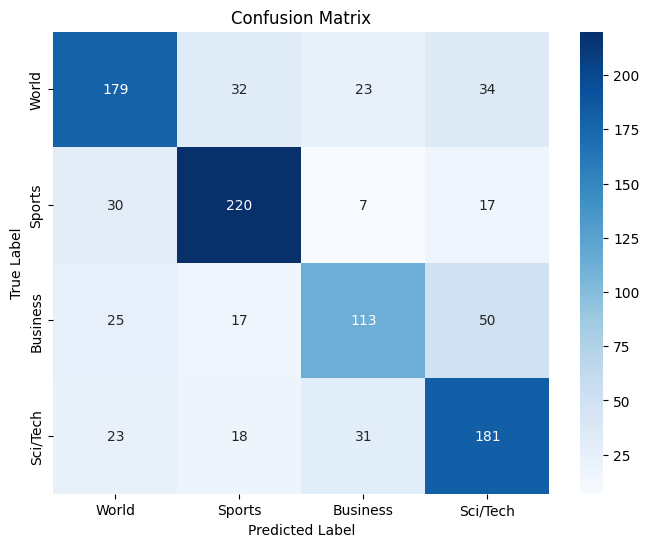


--- Evaluation Finished ---


In [14]:
"""
Section 14: Evaluation

Evaluate the trained model on the test dataset.
Calculate and display metrics like accuracy, classification report (precision,
recall, F1-score), and a confusion matrix.
"""
print("\n--- Section 14: Starting Evaluation ---")
model.eval() # Set the model to evaluation mode (disables dropout, etc.)

all_preds = []
all_labels = []

# Disable gradient calculations during evaluation for efficiency
with torch.no_grad():
    # Iterate over batches in the test data loader
    for batch in test_dataloader:
        # Move batch data to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(batch)

        # Find the class index with the highest score (the predicted class)
        predictions = torch.argmax(outputs, dim=1)

        # Move predictions and true labels to CPU and store them as numpy arrays
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch['label'].cpu().numpy())

# Calculate metrics using scikit-learn
accuracy = accuracy_score(all_labels, all_preds)
# Generate a detailed report per class
report = classification_report(all_labels, all_preds, target_names=label_map.values(), digits=4)
# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n--- Evaluation Results ---")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Plot Confusion Matrix using Seaborn
print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show() # Display the plot

print("\n--- Evaluation Finished ---")

In [15]:
"""
Section 15: Final Timings

Calculate and print the total execution time for the entire notebook.
"""
print("\n--- Section 15: Final Timings ---")
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes).")
print("\n")


--- Section 15: Final Timings ---
Total execution time: 22.11 seconds (0.37 minutes).




In [16]:
"""
Section 16: Optional: Example Prediction

Demonstrate how to use the trained model to predict the class for a
single, new sentence.
"""
print("\n--- Section 16: Example Prediction ---")
# Define a new sentence
text = "The latest space mission successfully launched yesterday evening."
print(f"Input Sentence: '{text}'")

model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # Disable gradients for prediction
    # 1. Tokenize the input text using the same tokenizer and settings
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LENGTH)
    # Note: return_tensors="pt" directly creates PyTorch tensors.

    # 2. Move tokenized inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Create the batch structure expected by the model's forward pass
    # Even for a single sentence, the model expects a batch dimension.
    batch = {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}

    # 4. Get model output (raw scores for each class)
    output = model(batch) # Shape: [1, num_classes]

    # 5. Get the predicted class index by finding the index with the highest score
    prediction_idx = torch.argmax(output, dim=1).item() # .item() gets the Python integer from the tensor

    # 6. Map the predicted index back to the readable label name
    predicted_label = label_map.get(prediction_idx, 'Unknown') # Use the label_map defined earlier

    print(f"Predicted class index: {prediction_idx}")
    print(f"Predicted label: {predicted_label}")
print("\n--- End of Notebook ---")


--- Section 16: Example Prediction ---
Input Sentence: 'The latest space mission successfully launched yesterday evening.'
Predicted class index: 3
Predicted label: Sci/Tech

--- End of Notebook ---
